#### Import Necessary Libraries ####

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### read all the data ####

In [3]:
#Specifiy the path
filepath = 'F:/vedantu/assignment/assignment/data_sets'

#import data files
customer_feature = pd.read_csv(filepath + "/customer_features.csv")
last_month_assort = pd.read_csv(filepath + "/last_month_assortment.csv")
next_month_assort = pd.read_csv(filepath + "/next_month_assortment.csv")
next_purchase_order = pd.read_csv(filepath + "/next_purchase_order.csv")
original_purchase_order = pd.read_csv(filepath + "/original_purchase_order.csv")
product_features = pd.read_csv(filepath + "/product_features.csv")

print("customer features dataframe shape:{}".format(customer_feature.shape))
print("last month assortment dataframe shape:{}".format(last_month_assort.shape))
print("next month assortment dataframe shape:{}".format(next_month_assort.shape))
print("next purchase order dataframe shape:{}".format(next_purchase_order.shape))
print("original purchase order dataframe shape:{}".format(original_purchase_order.shape))
print("product features dataframe shape:{}".format(product_features.shape))

customer features dataframe shape:(12000, 4)
last month assortment dataframe shape:(36000, 3)
next month assortment dataframe shape:(56400, 2)
next purchase order dataframe shape:(300, 4)
original purchase order dataframe shape:(1000, 4)
product features dataframe shape:(1000, 5)


#### check what is the loan amount? ####

there is no missing (or) null information in the "original_purchase_order.csv" file

In [4]:
original_purchase_order['total_cost']=original_purchase_order[['quantity_purchased', 'cost_to_buy']].apply(lambda row: row['quantity_purchased'] * row['cost_to_buy'], axis=1)

loan_amount = original_purchase_order['total_cost'].sum()

print("total loan amount:{}".format(loan_amount))

total loan amount:135546.41999999998


#### check next purchase order total amount ? ####

there are no missing value (or) null information in the "next_purchase_order.csv" file

In [5]:
next_purchase_order['total_cost'] = next_purchase_order[['quantity_purchased', 'cost_to_buy']].apply(lambda row: row['quantity_purchased'] * row['cost_to_buy'], axis=1)

next_purchase_order_amount = next_purchase_order['total_cost'].sum()

print("amount spent for next purchase order:{}".format(next_purchase_order_amount))

amount spent for next purchase order:24155.510000000002


#### money made back from customer ####

In [6]:
#get only product_id where book the is purchased or not
onlypurchasedBook = last_month_assort[last_month_assort['purchased'] == True]

#check the retail price for all those books and do sum 
#to check what money we made back from the customer

orgpo_copy = original_purchase_order.copy() #original purchase order copy
orgpo_copy = orgpo_copy.set_index(original_purchase_order.product_id)

moneymadeback = orgpo_copy.loc[onlypurchasedBook['product_id'].tolist()]['retail_value'].sum()
print("total money made back by selling books:{}".format(moneymadeback))

#see the shipping charge
shippingcharge = last_month_assort.shape[0] * 0.60
print("total shipping charge for last month:{}".format(shippingcharge))

total money made back by selling books:151617.36
total shipping charge for last month:21600.0


### preprocess dataset ###

#### check genres from the customer_features.csv dataset ####

In [7]:
uniqueGenres = []
genresFreq = []

for genres in customer_feature['favorite_genres']:
    #replace the word 
    word = genres.replace("[","")
    word = word.replace("]","")
    word = word.replace("'","")
    #split by comma
    wordslist = word.split(",")
    #iterate through the list
    if len(wordslist) != 0:
        for genr in wordslist:
            genresFreq.append(genr)
            if genr not in uniqueGenres:
                uniqueGenres.append(genr)
            else:
                pass

print("total number of genres:{}".format(len(uniqueGenres)))

total number of genres:23


In [8]:
#remove space constraints here
def removeSpace(col):
    cols = []
    for x in col:
        sp = x.replace(" ",'')
        cols.append(sp)
    
    return cols
        
uniqueGenres = list(set(removeSpace(uniqueGenres)))
genresFreq = removeSpace(genresFreq)

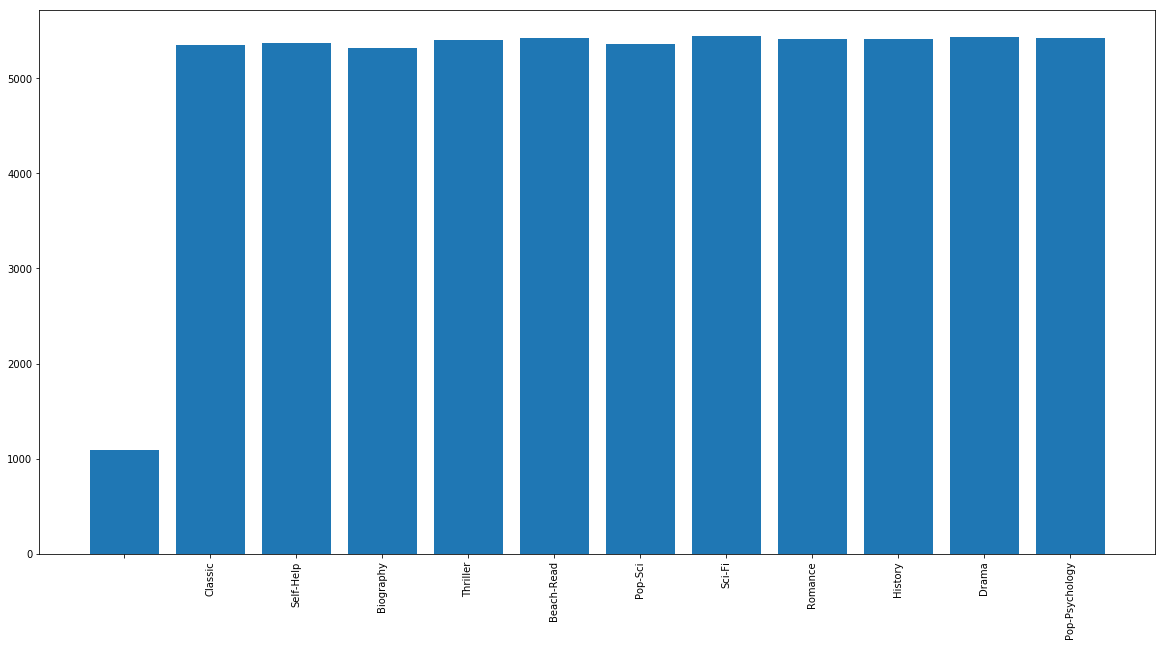

In [9]:
from collections import Counter
frequency = Counter(genresFreq)

plt.figure(figsize=(20, 10))
plt.bar(range(len(frequency)), list(frequency.values()), align='center')
plt.xticks(range(len(frequency)), list(frequency.keys()), rotation='vertical')

plt.show()

from the above graph we can see, what are the top picks for the customers.

#### convert favorite genres to one hot encoding ####

In [10]:
#get total length of the customers
def convertIntoList(genaslist):
     #replace the word 
    word = genaslist.replace("[","")
    word = word.replace("]","")
    word = word.replace("'","")
    #split by comma
    wordslist = word.split(",")
    
    #remove space here
    afterremovalSpace = removeSpace(wordslist)
    
    return afterremovalSpace

def oneHotEncode(df):
    no_of_customers = []
    
    #get index of each uniqueGenres that customer likes
    df = df.reset_index(0)
    for row in range(df.shape[0]):
        genre_list = [0]*len(uniqueGenres)
        #get the subsetdf
        subsetdf = df.iloc[row]['favorite_genres']
        genlist = convertIntoList(subsetdf)
        
        #get the index for unique
        indexlist = [uniqueGenres.index(genre) for genre in genlist]
        
        for ind in indexlist:
            genre_list[ind] = 1
        
        no_of_customers.append(genre_list)
    
    return no_of_customers

onehotfeatures = oneHotEncode(customer_feature)

In [11]:
#convert above feature into the dataframe
onehotdf = pd.DataFrame(onehotfeatures, columns=uniqueGenres)
onehotdf.shape

(12000, 12)

In [12]:
#concatenate the above dataframe with customer_features
concat_customerfeature = pd.concat([customer_feature, onehotdf], axis=1)
concat_customerfeature.shape
#drop favorite_genres feature in the dataset
concat_customerfeature = concat_customerfeature.drop(['favorite_genres'], axis=1)

In [13]:
#see favorite genre by age_bucket
age_gby = concat_customerfeature.groupby(['age_bucket']).agg(['sum'])
age_gby = pd.DataFrame(age_gby)
age_gby = age_gby.drop(['customer_id', 'is_returning_customer'], axis=1)
age_gby.to_csv("ageWiseinsights.csv", sep=",")

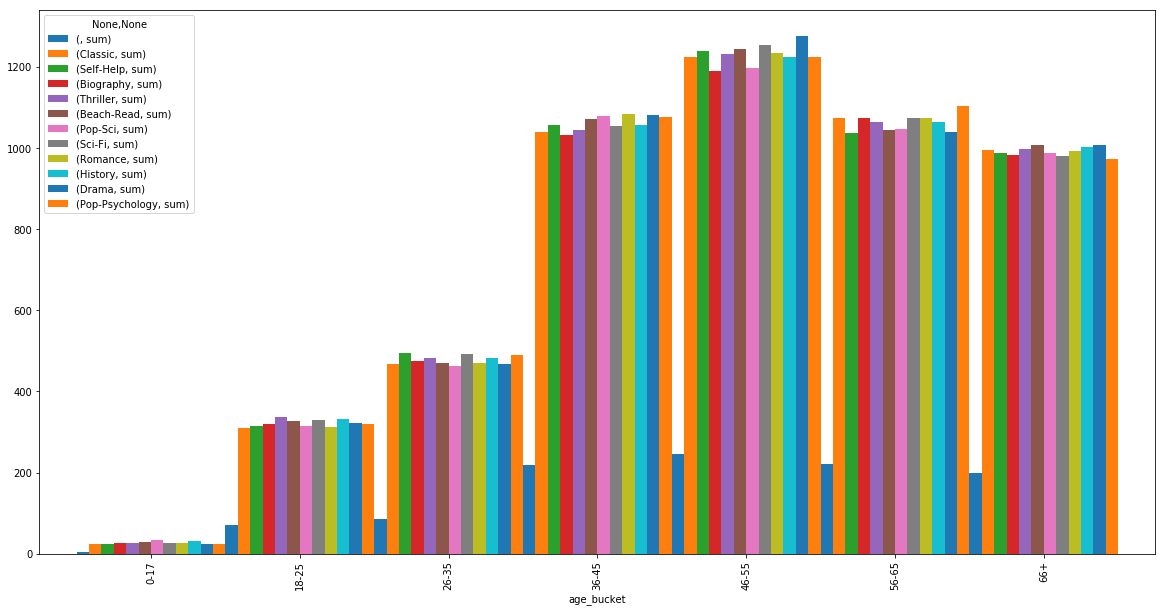

In [14]:
age_gby.plot.bar(figsize=(20, 10), width=1.0)
plt.show()

In [15]:
concat_customerfeature.columns

Index(['customer_id', 'age_bucket', 'is_returning_customer', '', 'Classic',
       'Self-Help', 'Biography', 'Thriller', 'Beach-Read', 'Pop-Sci', 'Sci-Fi',
       'Romance', 'History', 'Drama', 'Pop-Psychology'],
      dtype='object')

from the above observation w.k.t age bucket between 46-55 read of lot of books.

In [16]:
concat_customerfeature.columns = ['customer_id', 'age_bucket', 'is_returning_customer', 'notKnown', 'Biography',
       'Self-Help', 'History', 'Beach-Read', 'Sci-Fi', 'Drama', 'Thriller',
       'Pop-Psychology', 'Classic', 'Romance', 'Pop-Sci']

concat_customerfeature.head()

,customer_id,age_bucket,is_returning_customer,notKnown,Biography,Self-Help,History,Beach-Read,Sci-Fi,Drama,Thriller,Pop-Psychology,Classic,Romance,Pop-Sci
0,1000078,46-55,True,0,1,1,0,1,1,1,1,1,1,0,1
1,1000102,46-55,True,0,0,1,1,0,1,1,1,0,0,1,1
2,1000185,46-55,True,0,0,1,0,0,1,0,0,1,0,0,1
3,1000423,26-35,True,0,1,0,0,0,0,0,0,0,0,1,0
4,1000696,66+,True,0,0,0,1,1,1,0,1,1,1,1,0


#### check in last_month_assortment what type of books sold  ####

In [17]:
prdfeat_copy = product_features.copy() #copy dataframe for product features
prdfeat_copy = prdfeat_copy.set_index('product_id')

from collections import defaultdict 

prdfeatures_dict = defaultdict(int)

for k, v in zip(prdfeat_copy.index.tolist(),  prdfeat_copy.to_dict(orient='records')):
    prdfeatures_dict[k] = v

In [18]:
lsma_copy = last_month_assort.copy() #copy of last month assort
lsma_copy['fiction'] = lsma_copy.apply(lambda row: prdfeatures_dict[row['product_id']]['fiction'], axis=1)
lsma_copy['genre'] = lsma_copy.apply(lambda row: prdfeatures_dict[row['product_id']]['genre'], axis=1)

In [19]:
lsma_copy.groupby(['purchased', 'fiction']).agg(['count'])

customer_id product_id  genre
                        count      count  count
purchased fiction                              
False     False          9139       9139   9139
          True          14182      14182  14182
True      False          3442       3442   3442
          True           9237       9237   9237

In [20]:
lsma_copy.head()

,customer_id,product_id,purchased,fiction,genre
0,1000078,1730073,False,True,Drama
1,1000078,1470520,False,True,Romance
2,1000078,1861356,False,True,Thriller
3,1000078,1240824,True,True,Classic
4,1000078,1155460,False,True,Thriller


In [21]:
concat_customerfeature[concat_customerfeature['customer_id'] == 1000078]

,customer_id,age_bucket,is_returning_customer,notKnown,Biography,Self-Help,History,Beach-Read,Sci-Fi,Drama,Thriller,Pop-Psychology,Classic,Romance,Pop-Sci
0,1000078,46-55,True,0,1,1,0,1,1,1,1,1,1,0,1


####  left join lsma_copy and feature intrest ####

In [22]:
#left dataframe = lsma_copy
#right dataframe = concat_customerfeature
left_join = pd.merge(lsma_copy, concat_customerfeature, on='customer_id', how='left')
left_join.shape

(36000, 19)

In [23]:
#get the book price from the product_features.csv files
nrows = left_join.shape[0]
retail_price = []

for i in range(nrows):
    #get the data
    subsetdf = left_join.iloc[i]['product_id']
    #locate the retail price in orgpo_copy data
    rp = orgpo_copy[orgpo_copy['product_id'] == subsetdf]['retail_value'].values[0]
    retail_price.append(rp)

In [24]:
left_join['retailPrice'] = retail_price #set the column in the dataframe

#### check if we have all customer interest data in the customer_features.csv file ####

In [25]:
nextmonth_customer = next_month_assort.customer_id.unique().tolist()
customer_lookup = customer_feature.customer_id.unique().tolist()

In [26]:
[x for x in nextmonth_customer if x not in customer_lookup]

[]

So, in the test data we have all customer id which is also present in the customer feature lookup data

#### sample modeling  ####

try the models with the data we have!

In [27]:
#convert categorical variable to label encoding
def label_encoding(asSeries):
    encoding = []
    #get unique values
    uniqueList = sorted(asSeries.unique().tolist())
    #iterate through the asSeries
    for ser in asSeries:
        #get index of that value in uniqueList
        index = uniqueList.index(ser)
        encoding.append(index)
        
    return encoding

target_label = label_encoding(left_join['purchased'])
fiction_label = label_encoding(left_join['fiction'])
isReturning_label = label_encoding(left_join['is_returning_customer'])
genre_label = label_encoding(left_join['genre'])

In [28]:
left_join['age_bucket'] = left_join['age_bucket'].fillna('')
age_label = label_encoding(left_join['age_bucket'])

In [29]:
#split the dataset
input_features = ['Biography','Self-Help','History','Beach-Read',
 'Sci-Fi','Drama','Thriller','Pop-Psychology','Classic','notKnown',
 'Romance','Pop-Sci', 'retailPrice', 'fiction_label', 'isReturning_label',
 'genre_label', 'age_label']

target = 'target_label'

#add all those column in the dataset
left_join['fiction_label'] = fiction_label
left_join['target_label'] = target_label
left_join['isReturning_label'] = isReturning_label
left_join['age_label'] = age_label
left_join['genre_label'] = genre_label

#split input and output
X, y = left_join[input_features], left_join[target]

In [30]:
y.value_counts()

0    23321
1    12679
Name: target_label, dtype: int64

In [31]:
#split the dataset into train and validate
from sklearn.model_selection import train_test_split

X_train, evalX, y_train, evalY = train_test_split(
    X, y, test_size = 0.1,
    random_state=12)

print(X_train.shape, y_train.shape, evalX.shape, evalY.shape)

(32400, 17) (32400,) (3600, 17) (3600,)


### xgb classifier ###

In [66]:
import xgboost as xgb 
from sklearn.metrics import accuracy_score, roc_auc_score

def xgb_model(train_data, train_label, test_data, test_label):
    clf = xgb.XGBClassifier(max_depth=7,
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=500,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
    clf.fit(train_data, train_label, eval_metric='auc', verbose=True,
            eval_set=[(test_data, test_label)], early_stopping_rounds=100)
    y_pre = clf.predict(test_data)
    y_pro = clf.predict_proba(test_data)[:, 1]
    
    print("AUC Score:{}".format(roc_auc_score(test_label, y_pro)))
    print("Accuracy:{}".format(accuracy_score(test_label, y_pre)))
    
    return clf, y_pre
          

xgb_clf, xgb_prediction = xgb_model(X_train.as_matrix(), y_train, evalX.as_matrix(), evalY)

[0]	validation_0-auc:0.63768
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.64172
[2]	validation_0-auc:0.647345
[3]	validation_0-auc:0.655797


c:\users\madhivarman\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


[4]	validation_0-auc:0.656312
[5]	validation_0-auc:0.659954
[6]	validation_0-auc:0.663041
[7]	validation_0-auc:0.662822
[8]	validation_0-auc:0.664986
[9]	validation_0-auc:0.666627
[10]	validation_0-auc:0.666843
[11]	validation_0-auc:0.668568
[12]	validation_0-auc:0.669453
[13]	validation_0-auc:0.669618
[14]	validation_0-auc:0.67105
[15]	validation_0-auc:0.673397
[16]	validation_0-auc:0.675937
[17]	validation_0-auc:0.677639
[18]	validation_0-auc:0.678775
[19]	validation_0-auc:0.679598
[20]	validation_0-auc:0.679872
[21]	validation_0-auc:0.680801
[22]	validation_0-auc:0.682962
[23]	validation_0-auc:0.682711
[24]	validation_0-auc:0.687957
[25]	validation_0-auc:0.688703
[26]	validation_0-auc:0.689139
[27]	validation_0-auc:0.69081
[28]	validation_0-auc:0.692843
[29]	validation_0-auc:0.693163
[30]	validation_0-auc:0.693343
[31]	validation_0-auc:0.694162
[32]	validation_0-auc:0.69719
[33]	validation_0-auc:0.700185
[34]	validation_0-auc:0.700281
[35]	validation_0-auc:0.702316
[36]	validation_0

[265]	validation_0-auc:0.776034
[266]	validation_0-auc:0.776095
[267]	validation_0-auc:0.775806
[268]	validation_0-auc:0.775796
[269]	validation_0-auc:0.775884
[270]	validation_0-auc:0.775955
[271]	validation_0-auc:0.776083
[272]	validation_0-auc:0.775901
[273]	validation_0-auc:0.77597
[274]	validation_0-auc:0.776248
[275]	validation_0-auc:0.776039
[276]	validation_0-auc:0.77607
[277]	validation_0-auc:0.776272
[278]	validation_0-auc:0.776215
[279]	validation_0-auc:0.776267
[280]	validation_0-auc:0.775983
[281]	validation_0-auc:0.776053
[282]	validation_0-auc:0.776307
[283]	validation_0-auc:0.776288
[284]	validation_0-auc:0.776326
[285]	validation_0-auc:0.776401
[286]	validation_0-auc:0.776794
[287]	validation_0-auc:0.776888
[288]	validation_0-auc:0.776991
[289]	validation_0-auc:0.777184
[290]	validation_0-auc:0.777247
[291]	validation_0-auc:0.777245
[292]	validation_0-auc:0.777238
[293]	validation_0-auc:0.777046
[294]	validation_0-auc:0.776968
[295]	validation_0-auc:0.777207
[296]	vali

In [67]:
X_train.head()

,Biography,Self-Help,History,Beach-Read,Sci-Fi,Drama,Thriller,Pop-Psychology,Classic,notKnown,Romance,Pop-Sci,retailPrice,fiction_label,isReturning_label,genre_label,age_label
32296,1,0,0,0,0,0,0,0,0,0,0,0,12.87,0,1,1,4
1423,1,1,1,1,1,1,1,1,0,0,1,1,12.31,1,1,2,7
2685,1,1,0,1,0,1,0,0,1,0,1,0,9.16,1,0,0,3
3110,1,1,1,1,0,1,1,0,0,0,1,1,13.48,1,1,7,3
15177,1,1,0,0,0,1,0,0,0,0,0,1,16.20,1,1,2,3


In [68]:
predictiondf = pd.DataFrame({'actual': evalY, 'prediction':xgb_prediction})

In [69]:
predictiondf.to_csv("spaceremoval_prediction.csv", sep=",")

####  checking model stability ####

In [70]:
from imblearn.metrics import classification_report_imbalanced

print("XGB Model Metrics")
print(classification_report_imbalanced(evalY, xgb_prediction))

XGB Model Metrics
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.87      0.48      0.80      0.65      0.44      2285
          1       0.68      0.48      0.87      0.57      0.65      0.41      1315

avg / total       0.72      0.73      0.63      0.72      0.65      0.43      3600



In [37]:
### save the model as joblib ###

import pickle

pickle.dump(xgb_clf, open("finalModel.pickle.dat", "wb"))

#### predict for the test data ####

In [38]:
concat_customerfeature =concat_customerfeature.set_index('customer_id') #setting customer id as index

In [39]:
test_nrows = next_month_assort.shape[0]
isfiction, genre = [], []

test_customer_intrests =[] #empty dataframe

for i in range(test_nrows):
    #set the dataframe
    getdf = next_month_assort.iloc[i]['product_id']
    custdf = next_month_assort.iloc[i]['customer_id']
    #get the product features
    isfiction.append(prdfeat_copy.loc[getdf]['fiction'])
    genre.append(prdfeat_copy.loc[getdf]['genre'])
    #customer intrest dataframe
    cdf = concat_customerfeature.loc[custdf].values.tolist()
    #concatdf
    test_customer_intrests.append(cdf)
    
    if i % 5000 == 0 and i!=0:
        print("{} rows, Finished fetching product details and customer intrests data".format(i))

5000 rows, Finished fetching product details and customer intrests data
10000 rows, Finished fetching product details and customer intrests data
15000 rows, Finished fetching product details and customer intrests data
20000 rows, Finished fetching product details and customer intrests data
25000 rows, Finished fetching product details and customer intrests data
30000 rows, Finished fetching product details and customer intrests data
35000 rows, Finished fetching product details and customer intrests data
40000 rows, Finished fetching product details and customer intrests data
45000 rows, Finished fetching product details and customer intrests data
50000 rows, Finished fetching product details and customer intrests data
55000 rows, Finished fetching product details and customer intrests data


In [40]:
nextmonth_copy = next_month_assort.copy()

#appended fiction and genre label
nextmonth_copy['fiction_label'] = isfiction
nextmonth_copy['genre_label'] = genre

In [41]:
print(len(test_customer_intrests), nextmonth_copy.shape)

56400 (56400, 4)


In [42]:
#convert into dataframe
testCustdf = pd.DataFrame(test_customer_intrests, columns=concat_customerfeature.columns.tolist())
testCustdf.shape

(56400, 14)

In [43]:
#concat the dataframe
testdf = pd.concat([nextmonth_copy, testCustdf], axis=1)
testdf.shape

(56400, 18)

In [44]:
testdf['age_bucket'] = testdf['age_bucket'].fillna('')

In [45]:
#add all those column in the dataset
testdf['fiction_label'] = label_encoding(testdf['fiction_label'])
testdf['isReturning_label'] = label_encoding(testdf['is_returning_customer'])
testdf['age_label'] = label_encoding(testdf['age_bucket'])
testdf['genre_label'] = label_encoding(testdf['genre_label'])

#### concat retail price for the next assortment books ####

In [46]:
npo_copy = next_purchase_order.copy().set_index("product_id")
npo_copy.head()

,quantity_purchased,cost_to_buy,retail_value,total_cost
product_id,,,,
1479507,39,1.82,12.68,70.98
1681385,55,1.73,12.88,95.15
1771749,37,1.26,10.38,46.62
1605149,49,1.47,11.27,72.03
1861356,34,1.98,10.41,67.32


In [47]:
#check if all the product_id are present the next month assortment

#product id not in the next purchase order list
pdid_notin_nextmonthlist = [x for x in testdf['product_id'] if x not in npo_copy.index.tolist()]
print(len(pdid_notin_nextmonthlist))

39733


In [48]:
#check if those product id are the previous month list
opo_copy = original_purchase_order.copy().set_index("product_id")
opo_copy.head()

,quantity_purchased,cost_to_buy,retail_value,total_cost
product_id,,,,
1769808,77,2.20,16.67,169.40
1896283,67,1.46,9.59,97.82
1889979,80,2.06,13.36,164.80
1341288,85,1.25,6.57,106.25
1666328,60,1.51,10.49,90.60


In [49]:
[x for x in pdid_notin_nextmonthlist if x not in opo_copy.index.tolist()]

[]

In [50]:
#all the items that are not present in the next_purchase_order is
#present in the original purchase order

#concat next_purchase_order and original_purchase order
nmpo_req = next_purchase_order[['product_id', 'retail_value']] #next month purchase order required
opo_req = original_purchase_order[['product_id', 'retail_value']] #original purchase order required

purchaseOrder = pd.concat([opo_req, nmpo_req], axis=0) #shape
purchaseOrder.shape

(1300, 2)

In [51]:
purchaseOrder = purchaseOrder.set_index('product_id') #set product value as an index

In [52]:
#now we have all purchase order book and retail value
#get the product_id retail value in the testdf
testRetailValue = testdf.apply(lambda row: purchaseOrder.loc[row['product_id']]['retail_value'], axis=1)

In [53]:
trv = [] #append the retail price
for x in testRetailValue:
    if type(x) != np.ndarray:
        trv.append(x)
    else:
        trv.append(x[0])

In [54]:
testdf['retailPrice'] = trv #append the retail price column

#get only input features
testdf_ips = testdf[input_features]
testdf_ips.shape

(56400, 17)

In [55]:
modelSortFeatures = ['retailPrice','isReturning_label','Pop-Psychology','Biography','Self-Help','History', 
                     'Beach-Read','Sci-Fi','Drama','Thriller','notKnown','fiction_label','age_label','Classic', 
                     'Romance','Pop-Sci','genre_label']

testdf_ips = testdf_ips[modelSortFeatures]
testdf_ips.head()

,retailPrice,isReturning_label,Pop-Psychology,Biography,Self-Help,History,Beach-Read,Sci-Fi,Drama,Thriller,notKnown,fiction_label,age_label,Classic,Romance,Pop-Sci,genre_label
0,12.88,0,1,1,1,1,1,0,1,1,0,1,6,1,0,1,8
1,14.11,0,1,1,1,1,1,0,1,1,0,1,6,1,0,1,8
2,10.77,0,1,1,1,1,1,0,1,1,0,1,6,1,0,1,3
3,13.60,0,1,1,1,1,1,0,1,1,0,1,6,1,0,1,0
4,9.37,0,1,1,1,1,1,0,1,1,0,0,6,1,0,1,9


In [65]:
testdf_ips.to_csv("testdf.csv", sep=",")

In [56]:
import pickle
loaded_model = pickle.load(open("finalModel.pickle.dat", "rb"))
# make predictions for test data
test_prediction = loaded_model.predict(testdf_ips.as_matrix())
#test_prediction = xgb_clf.predict(testdf_ips.as_matrix())

c:\users\madhivarman\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [57]:
#append the prediction to the next_month_assortment columns
nma_copy = next_month_assort.copy()
nma_copy['willbuy'] = test_prediction

In [58]:
#get the retail price for all the product id
nma_copy['retail_price'] = testdf_ips['retailPrice']
nma_copy.head()

,customer_id,product_id,willbuy,retail_price
0,1600785,1443029,0,12.88
1,1600785,1164138,0,14.11
2,1600785,1636511,0,10.77
3,1600785,1832547,1,13.60
4,1600785,1237420,0,9.37


In [59]:
nma_copy[['willbuy', 'retail_price']].groupby(['willbuy']).agg(['sum'])

,retail_price
,sum
willbuy,
0,523365.1
1,157418.2


In [80]:
nma_copy.to_csv("resultSales.csv", sep=",")

In [79]:
#next month shipping charge
nmsc = nma_copy.shape[0] * 0.60
nmsc

33840.0

### conclusion ###

1. total amount we get by selling next month assortment = 1,57,418
2. next month purchase order  = 24155.51
3. total loan amount = 135546.42

--------------------------------------------------------------------------------
1. next month purchase order + total loan amount = 1,59,701.42
2. shipping charge for next month assortment order = 33840.0
3. amount including shipping order = 1,93,541

---------------------------------------------------------------------------------

#### Question ####

Will we be able to both pay back our loan and afford our next book purchase order?

So, the with the sales we made by next month assortment batch We can able to pay back our loan and afford next month purchase order.

**No! with next batch sales we cannot payback our loan and next month book assortment. we need Rs:2,283 additional amount to pay back our loan**